In [6]:
import matplotlib.pyplot as plt
import numpy as np

from helper_tools import *
from storage_ring_modeler import StorageRingModel,make_optimal_solution_model
from phaseSpaceAnalyzer import SwarmSnapShot
from phaseSpaceAnalysis_Functions import make_phase_space_info,plot_ring_lattice_with_stops,emittance_from_particles,get_emittances
import time
from particle_class import Swarm
%matplotlib inline
model=make_optimal_solution_model('2',include_mag_cross_talk=True,sim_time_max=1000,include_misalignments=False)

In [11]:
swarm_traced=model.inject_swarm(parallel=True)

In [12]:
T_min=np.inf
swarm_valid=Swarm()
for particle in swarm_traced:
    if particle.T<T_min:
        swarm_valid.add(particle)
times=np.array([particle.T for particle in swarm_valid])
nums_revs=np.array([particle.revolutions for particle in swarm_valid])

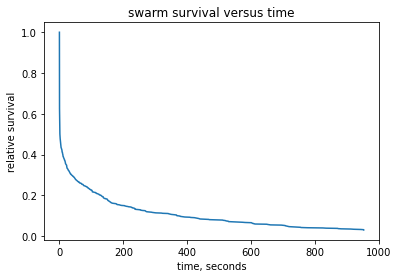

2460.1749597228913

In [13]:
#survival versus time
times_unique=np.unique(times)
nums_surviving_ring=np.array([np.sum(times>time) for time in times_unique])
frac_surviving_ring=nums_surviving_ring/np.max(nums_surviving_ring)
plt.title("swarm survival versus time")
plt.plot(times_unique[:-1],frac_surviving_ring[:-1])
plt.xlabel("time, seconds")
plt.ylabel("relative survival")
# plt.savefig("survival_raw",dpi=200)
plt.show()
sum([part.revolutions for part in swarm_valid])/len(swarm_valid)

In [24]:
from math import exp,log

def frac_OP(eps,revs):
    assert eps>0
    return eps**revs
def frac_vac(tau,time):
    assert tau>0
    return exp(-time/tau)
def OP_integral(eps,revs):
    return eps**(revs+1)/(revs+1)
def vac_flux_integral(tau,survival_time,revs):
    R=tau*revs/survival_time
    return R*(1-exp(-revs/R))
def revs_limited(tau,eps,num_revs,survival_time):
    R=tau*num_revs/survival_time
    val_b= R*eps**num_revs / (math.e**(num_revs/R) * (R*log(eps) -1))
    val_a= R / ( R*log(eps) -1)
    return val_b-val_a
def flux_mult(tau,eps):
    if tau<1e-3 or eps<1e-3:
        return 0.0
    flux=[]
    for time,revs in zip(times,nums_revs):
        if time!=0.0:
            flux.append(revs_limited(tau,eps,revs,time))
    return sum(flux)/swarm_valid.num_particles()
flux_mult(1e9,1.0)

2460.1739952117205

### full analysis

/var/folders/c3/_byqmhpx62b_f0jnb2ht27y40000gn/T/ipykernel_7657/2031168991.py:16: RuntimeWarning: overflow encountered in double_scalars
  val_b= R*eps**num_revs / (math.e**(num_revs/R) * (R*log(eps) -1))


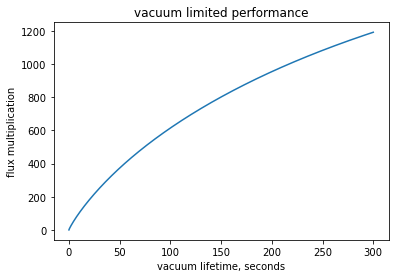

In [15]:
#tau analysis
epsilon=1
tau_values=np.linspace(0,300,1000)
fluxes=[]
for tau_vacuum in tau_values:
    fluxes.append(flux_mult(tau_vacuum,epsilon))
plt.title("vacuum limited performance")
plt.plot(tau_values,fluxes)
plt.xlabel("vacuum lifetime, seconds")
plt.ylabel("flux multiplication")
plt.savefig("vacuum_perf",dpi=200)
plt.show()

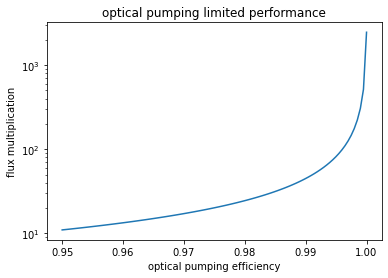

2460.1739952117205

In [19]:
#epsilon analysis
tau_vacuum=1e9
epsilon_values=np.linspace(.95,1,100)
fluxes=[]
for epsilon in epsilon_values:
    fluxes.append(flux_mult(tau_vacuum,epsilon))
plt.title("optical pumping limited performance")
plt.semilogy(epsilon_values,fluxes)
plt.xlabel("optical pumping efficiency")
plt.ylabel("flux multiplication")
plt.savefig("opt_perf",dpi=200)
plt.show()
max(fluxes)

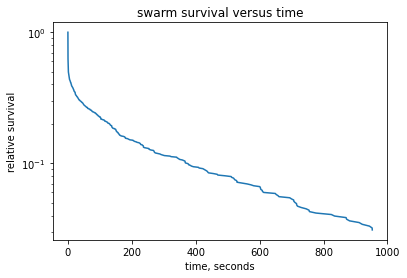

In [18]:
#survival versus time
times_unique=np.unique(times)
nums_surviving_ring=np.array([np.sum(times>time) for time in times_unique])
frac_surviving_ring=nums_surviving_ring/np.max(nums_surviving_ring)
plt.title("swarm survival versus time")
plt.semilogy(times_unique[:-1],frac_surviving_ring[:-1])
plt.xlabel("time, seconds")
plt.ylabel("relative survival")
plt.savefig("survival_raw",dpi=200)
plt.show()

In [27]:
flux_mult(73,.9998)

390.60616868952843

### ideal vacuum and ring, imperfect optical pumping

In [113]:
raise NotImplemented #i think I broke all this
tau_vacuum=np.inf
eps_OP=1.0
t_maxes=np.logspace(np.log10(1.0),np.log10(300),100)
epsilons_OP=[.98,.99,.999,1.0]

flux_ideal=[]
flux_epsilons=[[] for _ in epsilons_OP]
for t_max in t_maxes:
    times=np.linspace(0.0,t_max,10_000)
    frac_surviving_ring=np.ones(len(times))
    flux_ideal.append(flux_mult(time_one_rev,np.inf,1.0,frac_surviving_ring,times))
    for fluxes,eps in zip(flux_epsilons,epsilons_OP):
        flux=flux_mult(time_one_rev,np.inf,eps,frac_surviving_ring,times)
        fluxes.append(flux)


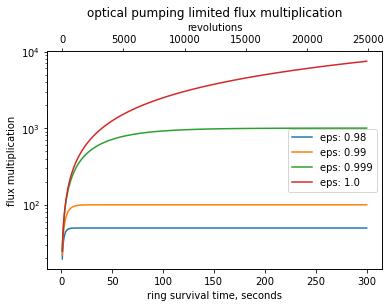

7462.931890215425

In [133]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
for fluxes,eps in zip(flux_epsilons,epsilons_OP):
    ax1.semilogy(t_maxes,fluxes,label='eps: '+str(eps))

ax2.plot(nums_revs,100*np.ones(len(nums_revs)),alpha=0.0)
ax1.set_xlabel("ring survival time, seconds")
ax1.set_ylabel("flux multiplication")
ax2.set_xlabel('revolutions')
ax1.legend()
plt.title("optical pumping limited flux multiplication")
plt.show()
flux_epsilons[-1][-1]

### ideal optical pumping and ring, imperfect vacuum

In [123]:


eps_OP=1.0
t_maxes=np.logspace(np.log10(1.0),np.log10(300),100)
taus_vacuum=[10,50,100,np.inf]
flux_ideal=[]
fluxes_vac=[[] for _ in epsilons_OP]
for t_max in t_maxes:
    times=np.linspace(0.0,t_max,10_000)
    frac_surviving_ring=np.ones(len(times))
    flux_ideal.append(flux_mult(time_one_rev,np.inf,1.0,frac_surviving_ring,times))
    for fluxes,tau in zip(fluxes_vac,taus_vacuum):
        flux=flux_mult(time_one_rev,tau,1.0,frac_surviving_ring,times)
        fluxes.append(flux)

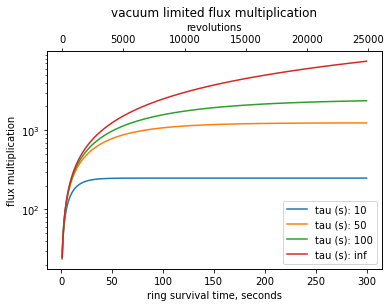

7462.931890215425

In [132]:
fig = plt.figure()

ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
for fluxes,tau in zip(fluxes_vac,taus_vacuum):
    ax1.semilogy(t_maxes,fluxes,label='tau (s): '+str(tau))

ax2.plot(nums_revs,100*np.ones(len(nums_revs)),alpha=0.0)
ax1.set_xlabel("ring survival time, seconds")
ax1.set_ylabel("flux multiplication")
ax2.set_xlabel('revolutions')
ax1.legend()
plt.title("vacuum limited flux multiplication")
plt.show()
fluxes_vac[-1][-1]